<a href="https://colab.research.google.com/github/kumiori/mec647/blob/main/mec647_Snippets_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
import sys

try:
    import google.colab  # noqa: F401
except ImportError:
    import ufl  # noqa: F401
    import dolfinx  # noqa: F401
else:
    try:
        import ufl
        import dolfinx
    except ImportError:
        !wget "https://fem-on-colab.github.io/releases/fenicsx-install.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh";
        import ufl  # noqa: F401
        import dolfinx  # noqa: F401

try:
    import pyvista
except ImportError:
    !{sys.executable} -m pip install --upgrade pyvista itkwidgets;
    import pyvista  # noqa: F401
    from pyvista.utilities import xvfb

try:
    import gmsh
except ImportError:
    !{sys.executable} -m pip install gmsh
    import gmsh

!sudo apt install libgl1-mesa-glx xvfb;
!{sys.executable} -m pip install pythreejs;
!{sys.executable} -m pip install ipygany;
!{sys.executable} -m pip install --upgrade PyYAML

## Snippets and Quick & Dirty tests

1. A gallery of meshes (automated?): TODO
1. Mesh refinement, global and local ✔️
1. Boolean operations on meshes: TODO


In [2]:
import matplotlib.pyplot as plt
from petsc4py import PETSc
import numpy as np
from mpi4py import MPI
comm = MPI.COMM_WORLD

# from dolfinx.fem import (
#     Constant,
#     Function,
#     FunctionSpace,
#     assemble_scalar,
#     dirichletbc,
#     form,
#     locate_dofs_geometrical,
#     set_bc,
# )

branch_name = 'main'

!rm -rf mec647
try:
  !git clone -b {branch_name} https://github.com/kumiori/mec647.git
  sys.path.append('mec647/')

  import mec647
  from mec647 import meshes
  from mec647.meshes import primitives
  from mec647.utils.viz import plot_mesh, plot_scalar, plot_vector

except Exception as e:
  print('Something went wrong', e)
  !rm -rf mec647
  !git clone https://github.com/kumiori/mec647.git



Cloning into 'mec647'...
remote: Enumerating objects: 1114, done.
remote: Counting objects: 100% (1114/1114), done.
remote: Compressing objects: 100% (836/836), done.
remote: Total 1114 (delta 560), reused 561 (delta 244), pack-reused 0
Receiving objects: 100% (1114/1114), 18.86 MiB | 12.86 MiB/s, done.
Resolving deltas: 100% (560/560), done.


## Meshes *galore*

The idea:
  - load the meshes module
  - for each mesh function:
    - get default parameters
    - create mesh
    - display mesh


In [5]:
branch_name = 'andres-plates'

!rm -rf mec647
try:
  !git clone -b {branch_name} https://github.com/kumiori/mec647.git
  sys.path.append('mec647/')

  print()
  print(f'Cloned brach: {branch_name}')
  print(f'Last commit message')
  !cd mec647/ && git log -n 1 && cd ..
  import mec647
  from mec647 import meshes
  from mec647.meshes.ikea import mesh_ikea_real as slab_with_holes
  from mec647.utils.viz import plot_mesh, plot_scalar, plot_vector
except Exception as e:
  print('Something went wrong', e)
  !rm -rf mec647
  !git clone https://github.com/kumiori/mec647.git

Cloning into 'mec647'...
remote: Enumerating objects: 1114, done.
remote: Counting objects: 100% (1114/1114), done.
remote: Compressing objects: 100% (836/836), done.
remote: Total 1114 (delta 560), reused 561 (delta 244), pack-reused 0
Receiving objects: 100% (1114/1114), 18.86 MiB | 11.98 MiB/s, done.
Resolving deltas: 100% (560/560), done.

Cloned brach: andres-plates
Last commit message
commit 197bd68ad3ab3ef1563bffc8cc7408715fe56774 (HEAD -> andres-plates, origin/andres-plates)
Author: andres <leon.baldelli@cnrs.fr>
Date:   Fri Feb 25 15:30:10 2022 +0100

    crackholes & kink rev


Point (1) = { 0, 1.0, 0, 0.012566370614359173 };
Point (2) = { 0, 0, 0, 0.012566370614359173 };
Point (3) = { 1.0, 0, 0, 0.1 };
Point (4) = { 1.0, 1.0, 0, 0.1 };
Point (5) = { 0.04000000000000001, 0.05, 0, 0.012566370614359173 };
Point (6) = { 0.06000000000000001, 0.05, 0, 0.012566370614359173 };
Point (7) = { 0.04000000000000001, 0.07, 0, 0.012566370614359173 };
Point (8) = { 0.020000000000000004, 0.05, 0, 0.012566370614359173 };
Point (9) = { 0.04000000000000001, 0.03, 0, 0.012566370614359173 };
Circle (1) = { 6, 5, 7 };
Circle (2) = { 7, 5, 8 };
Circle (3) = { 8, 5, 9 };
Circle (4) = { 9, 5, 6 };
Line Loop (1) = { 1, 2, 3, 4 };
Point (11) = { 0.04000000000000001, 0.15000000000000002, 0, 0.012566370614359173 };
Point (12) = { 0.06000000000000001, 0.15000000000000002, 0, 0.012566370614359173 };
Point (13) = { 0.04000000000000001, 0.17, 0, 0.012566370614359173 };
Point (14) = { 0.020000000000000004, 0.15000000000000002, 0, 0.012566370614359173 };
Point (15) = { 0.04000000000000001, 0.1

Exception: ignored

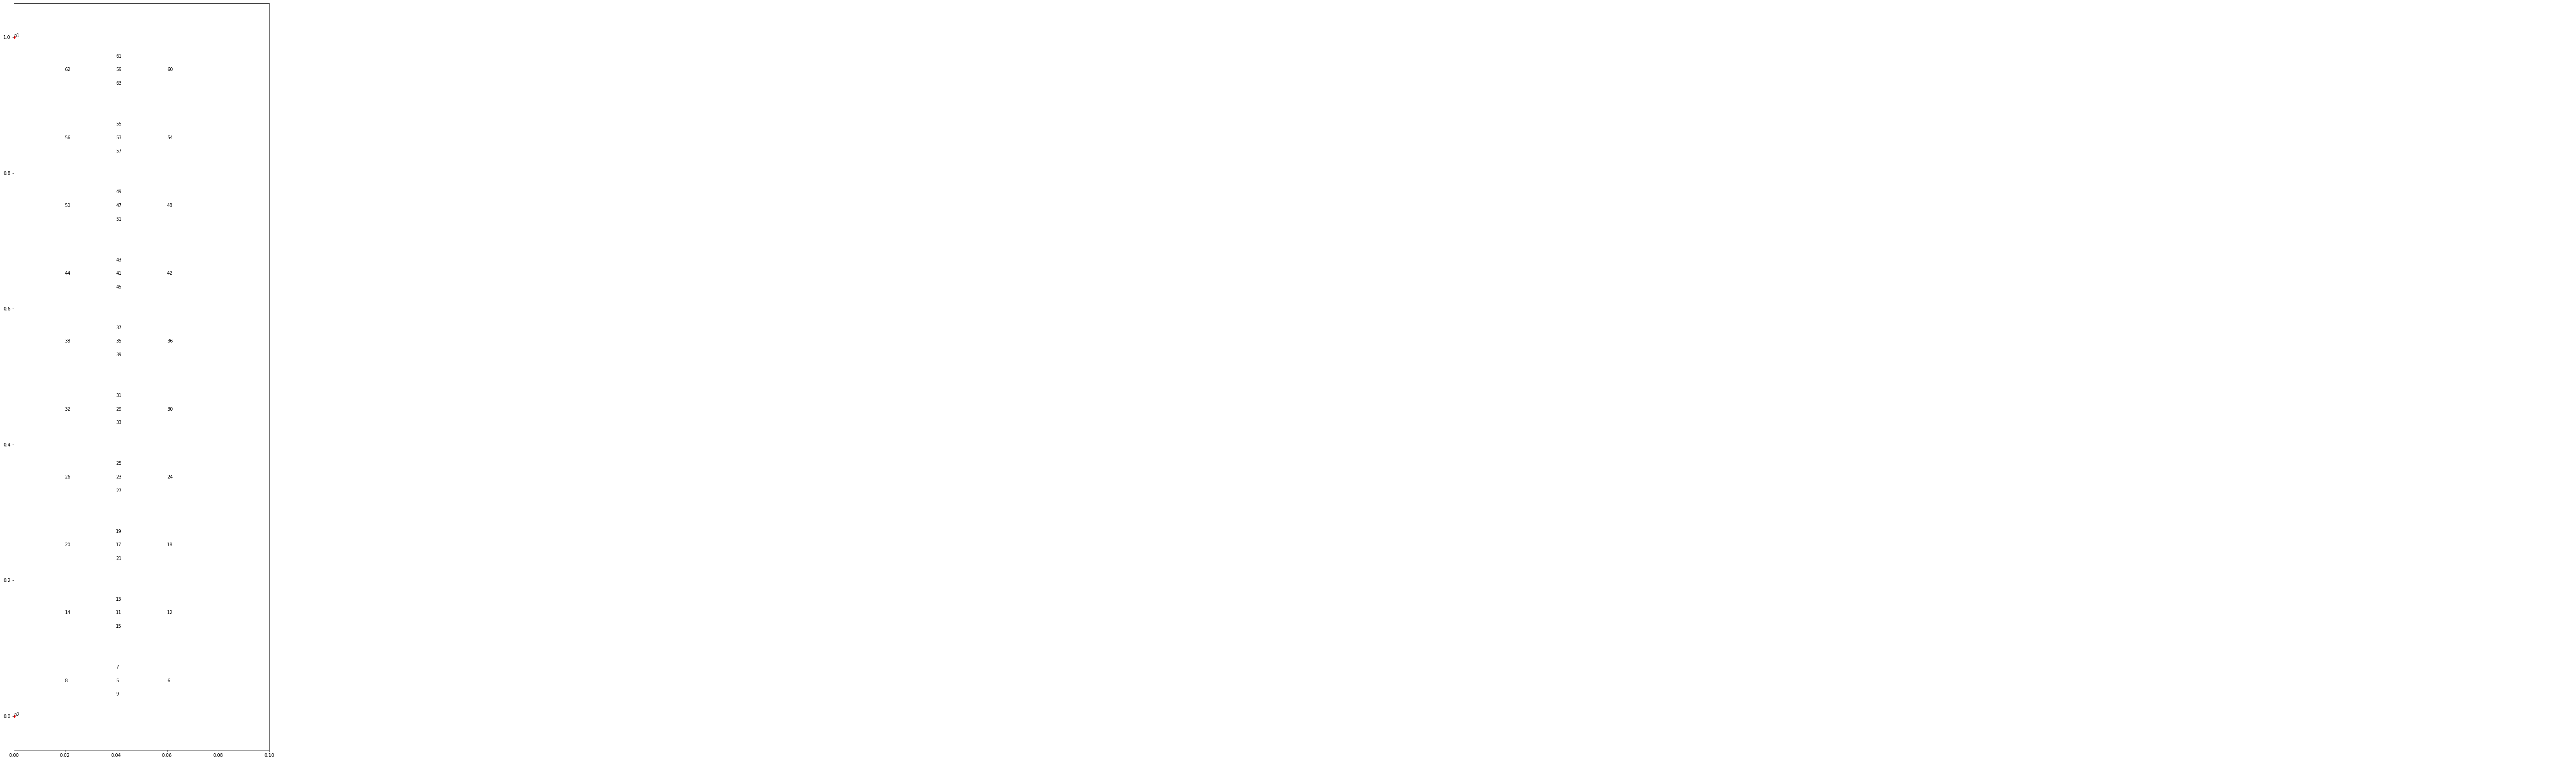

In [4]:
# %%capture
from dolfinx.io import XDMFFile
from mec647.meshes import gmsh_model_to_mesh
from mpi4py import MPI
from pathlib import Path
# gmsh.finalize()
parameters = {
    'H': 1.,
    'L': 1.,
    'n': 10,
    'cx': .1,
    'h': .3,
    'cy': 0.,
}
model, tdim, tag_names = slab_with_holes('perforated_slab',
                geom_parameters=parameters,
                lc=.1,
                tdim=2,
                order=0,
                msh_file='perforated_slab.msh'
                )
mesh, mts = gmsh_model_to_mesh(
    model, cell_data=True, facet_data=False, gdim=tdim)


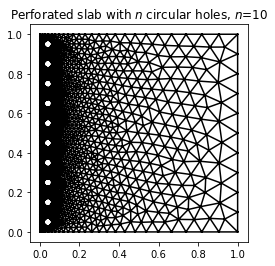

In [ ]:
from mec647.utils.viz import plot_mesh

plt.figure()
ax = plot_mesh(mesh)
fig = ax.get_figure()
plt.title(f"Perforated slab with $n$ circular holes, $n$={parameters.get('n')}")
fig.savefig(f"perforated_slab.png")

## Mesh refinement (at runtime)

Global (uniform) and local (selective) mesh refinement
at the boundary and in the bulk, done with the dolfinx
mesh module.




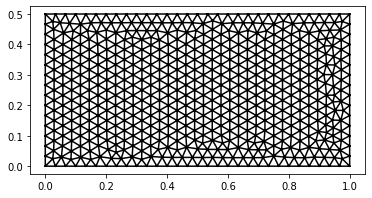

In [ ]:
parameters = {
    'geometry': {
        'geom_type': 'slab',
        'Lx': 1.,
        'Ly': .5,
    },
}

# Mesh
Lx = parameters["geometry"]["Lx"]
Ly = parameters["geometry"]["Ly"]
geom_type = parameters["geometry"]["geom_type"]
meshsize = Lx/30

gmsh_model, tdim = primitives.mesh_bar_gmshapi(geom_type,
                                    Lx, 
                                    Ly, 
                                    meshsize, 
                                    tdim=2)

mesh, mts = meshes.gmsh_model_to_mesh(gmsh_model,
                               cell_data=False,
                               facet_data=True,
                               gdim=2)

# TODO: Plot mesh


plt.figure()
ax = plot_mesh(mesh)
fig = ax.get_figure()
fig.savefig(f"mesh.png")

To refine, many options. Either at meshing time, or - as shown below - directly through dolfinx on the gmsh-exported mesh.

Note that, typically, meshing is done on one processor, prior to computations. For large problems (to be run on parallel computing machines), it is preferable to construct a relatively coarse mesh (on a single processor) and then refine it, distributing (cf. the `redistribute` optional argument in the function's signature) the newly created nodes optimally across the cpus. 





```def refine(mesh: Mesh, edges: np.ndarray = None, redistribute: bool = True) -> Mesh:```
The docstring of the refine function (in the mesh module)

    """Refine a mesh

    Args:
        mesh: The mesh from which to build a refined mesh
        edges: Optional argument to specify which edges should be refined. If
            not supplied uniform refinement is applied.
        redistribute:
            Optional argument to redistribute the refined mesh if mesh is a
            distributed mesh.

    Returns:
        A refined mesh
    """

### Refine globally (uniformly, by bisection)


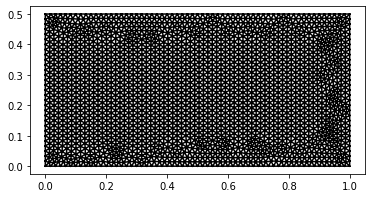

In [ ]:
mesh_refined_global = dolfinx.mesh.refine(mesh, redistribute=True)

plt.figure()
ax = plot_mesh(mesh_refined_global)
fig = ax.get_figure()
fig.savefig(f"mesh_refined_uniform.png")

### Refine locally, at a boundary


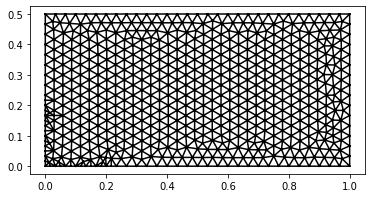

In [ ]:
# Create the topology (connection/connectivity) for edges (of dimension = tdim - 1)

mesh.topology.create_entities(tdim - 1)

def left_corner_edge(x):
    return np.logical_and(x[0] < Lx/4, x[1] < Ly/2)

edges = dolfinx.mesh.locate_entities_boundary(mesh, tdim-1, left_corner_edge)
mesh_refined_local = dolfinx.mesh.refine(mesh, edges, redistribute=False)


plt.figure()
ax = plot_mesh(mesh_refined_local)
fig = ax.get_figure()
fig.savefig(f"mesh_refined_local.png")

### Refine locally, in the volume


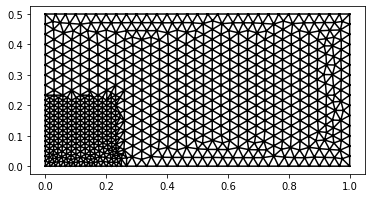

In [ ]:
# Create the topology (connection/connectivity) for edges (of dimension = tdim - 1)

mesh.topology.create_entities(tdim - 1)

def left_corner(x):
    return np.logical_and(x[0] < Lx/4, x[1] < Ly/2)

edges = dolfinx.mesh.locate_entities(mesh, tdim-1, left_corner)
mesh_refined_local2 = dolfinx.mesh.refine(mesh, edges, redistribute=False)


plt.figure()
ax = plot_mesh(mesh_refined_local2)
fig = ax.get_figure()
fig.savefig(f"mesh_refined_local_bulk.png")

## Crack Holes

In [7]:
branch_name = 'andres-plates'

!rm -rf mec647
try:
  !git clone -b {branch_name} https://github.com/kumiori/mec647.git
  sys.path.append('mec647/')

  print()
  print(f'Cloned brach: {branch_name}')
  print(f'Last commit message')
  !cd mec647/ && git log -n 1 && cd ..
  import mec647
  from mec647 import meshes
  from mec647.meshes.crackholes import mesh_crackholes as mesh_function
  from mec647.utils.viz import plot_mesh, plot_scalar, plot_vector
except Exception as e:
  print('Something went wrong', e)
  !rm -rf mec647
  !git clone https://github.com/kumiori/mec647.git

Cloning into 'mec647'...
remote: Enumerating objects: 1114, done.
remote: Counting objects: 100% (1114/1114), done.
remote: Compressing objects: 100% (836/836), done.
remote: Total 1114 (delta 560), reused 561 (delta 244), pack-reused 0
Receiving objects: 100% (1114/1114), 18.86 MiB | 12.22 MiB/s, done.
Resolving deltas: 100% (560/560), done.

Cloned brach: andres-plates
Last commit message
commit 197bd68ad3ab3ef1563bffc8cc7408715fe56774 (HEAD -> andres-plates, origin/andres-plates)
Author: andres <leon.baldelli@cnrs.fr>
Date:   Fri Feb 25 15:30:10 2022 +0100

    crackholes & kink rev


In [8]:
# %%capture
from dolfinx.io import XDMFFile
from mec647.meshes import gmsh_model_to_mesh
from mpi4py import MPI
from pathlib import Path
# gmsh.finalize()
parameters = {
    'geometry': {
        'geom_type': 'crackhole',
        # 'Lx': 1.0,
        # 'Ly': 0.5,
        # 'a': .5,
        # 'b': .2,
        # 'lc': .05,
        "Lx" : 1.,
        "Ly" : .5,
        "a" :  .5,
        "b" :  .2,
        "lc" :  .05,
        "xc": .1,
        "deltac": .1,
        "rhoc": .05,
        "offset": 0,
        "tdim" :  2,
        "order" :  0
    },
}
Lx = parameters.get("geometry").get("Lx")
Ly = parameters.get("geometry").get("Ly")
a = parameters.get("geometry").get("a")
#b=parameters.get("geometry").get("b")
geom_type = parameters.get("geometry").get("geom_type")

gmsh_model=mesh_function('crack_holes',
                        Lx,
                        Ly,
                        a = .5,
                        b = .2,
                        lc = .05,
                        xc=.1,
                        deltac=.1,
                        rhoc=.05,
                        offset=0,
                        tdim = 2,
                        order = 0
                        )

mesh, mts = gmsh_model_to_mesh(
    model, cell_data=True, facet_data=False, gdim=tdim)


Point (1) = { 0.0, 0.0, 0, 0.05 };
Point (2) = { 1.0, 0.0, 0, 0.05 };
Point (3) = { 1.0, 0.5, 0.0, 0.05 };
Point (4) = { 0, 0.5, 0, 0.05 };
Point (5) = { 0, 0.275, 0.0, 0.05 };
Point (6) = { 0.25, 0.275, 0, 0.025 };
Point (7) = { 0.35, 0.251, 0.0, 0.016666666666666666 };
Point (8) = { 0.4, 0.25, 0, 0.016666666666666666 };
Point (9) = { 0.35, 0.249, 0, 0.016666666666666666 };
Point (10) = { 0.25, 0.225, 0, 0.025 };
Point (11) = { 0, 0.225, 0, 0.05 };
Point (12) = { 0.1, 0.35, 0, 0.05 };
Point (13) = { 0.05, 0.35, 0, 0.05 };
Point (14) = { 0.1, 0.39999999999999997, 0, 0.05 };
Point (15) = { 0.15000000000000002, 0.35, 0, 0.05 };
Point (16) = { 0.1, 0.3, 0, 0.05 };
Point (17) = { 0.1, 0.15, 0, 0.05 };
Point (18) = { 0.05, 0.15, 0, 0.05 };
Point (19) = { 0.1, 0.2, 0, 0.05 };
Point (20) = { 0.15000000000000002, 0.15, 0, 0.05 };
Point (21) = { 0.1, 0.09999999999999999, 0, 0.05 };
Point (22) = { 0.5, 0.2, 0, 0.05 };
Point (23) = { 0.5, 0.21000000000000002, 0, 0.05 };
Point (24) = { 0.53, 0.2, 

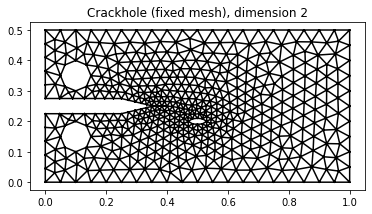

In [15]:
# Viz the mesh
Path("mec647/practice").mkdir(parents=True, exist_ok=True)

plt.figure()
ax = plot_mesh(mesh)
fig = ax.get_figure()
plt.title(f"Crackhole (fixed mesh), dimension {tdim}")
fig.savefig(f"mec647/practice/crackhole.png")